In [96]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

#Import some packages for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [97]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV

In [98]:
# path to the dataset
file_path = "Dry_Eye_Dataset.csv"

# Load the latest version of the file
df0 = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "dakshnagra/dry-eye-disease",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

/var/folders/h4/8_8xkn4579zbrdb79s7zrtl00000gp/T/ipykernel_11245/3521891120.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df0 = kagglehub.load_dataset(


In [99]:
df = df0.copy()

#Make everything lower case, and replace space with '_'
df.columns = [col.lower().replace(" ", "_").replace("-", "_").replace("itchiness/irritation_in_eye", 'eye_irritation') for col in df.columns]

# Split the blood_pressure column into two new columns
df[['systolic', 'diastolic']] = df['blood_pressure'].str.split('/', expand=True)

# Define the Blood Pressure Category
def categorize_bp(row):
    if 110 <= int(row['systolic']) <= 120 and 70 <= int(row['diastolic']) <= 80:
        return 'normal'
    elif int(row['systolic']) > 120 or int(row['diastolic']) > 80:
        return 'high'
    else:
        return 'low'
# New BP category column
df['bp_category'] = df.apply(categorize_bp, axis=1)

In [100]:
omit_cols = ['blood_pressure',
              'systolic',
              'diastolic']
df = df.drop(columns=omit_cols)

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   20000 non-null  object 
 1   age                      20000 non-null  int64  
 2   sleep_duration           20000 non-null  float64
 3   sleep_quality            20000 non-null  int64  
 4   stress_level             20000 non-null  int64  
 5   heart_rate               20000 non-null  int64  
 6   daily_steps              20000 non-null  int64  
 7   physical_activity        20000 non-null  int64  
 8   height                   20000 non-null  int64  
 9   weight                   20000 non-null  int64  
 10  sleep_disorder           20000 non-null  object 
 11  wake_up_during_night     20000 non-null  object 
 12  feel_sleepy_during_day   20000 non-null  object 
 13  caffeine_consumption     20000 non-null  object 
 14  alcohol_consumption   

In [102]:
df.head(20)

,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,medical_issue,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,dry_eye_disease,bp_category
0,F,24,9.5,2,1,67,3000,31,161,69,...,Y,Y,N,8.7,N,Y,Y,N,Y,high
1,M,39,9.6,2,3,60,12000,74,164,87,...,Y,Y,N,9.6,Y,N,N,Y,Y,low
2,F,45,5.4,1,5,95,12000,93,179,94,...,N,N,Y,4.0,N,Y,N,N,N,high
3,F,45,5.4,4,5,78,19000,32,160,77,...,Y,N,N,7.6,N,Y,N,Y,N,high
4,F,42,5.7,3,2,72,4000,173,179,99,...,Y,N,N,3.5,N,Y,Y,N,Y,low
5,F,42,5.8,3,1,79,14000,110,174,64,...,Y,Y,Y,2.6,Y,Y,N,Y,Y,high
6,M,26,4.8,5,2,63,6000,42,188,82,...,Y,Y,Y,5.4,Y,N,N,Y,Y,high
7,M,33,5.5,2,1,97,5000,71,162,91,...,N,Y,N,4.5,Y,Y,N,N,Y,high
8,M,36,6.3,1,2,78,7000,142,175,80,...,Y,N,N,3.9,Y,N,N,Y,N,high
9,M,33,7.7,4,5,81,4000,105,163,65,...,Y,Y,N,5.7,N,N,Y,Y,Y,high


In [103]:
categorical_features = list(df.dtypes[df.dtypes == 'object'].index)
for col in categorical_features:
    df[col] = df[col].str.lower()
print(df.iloc[1999])

gender                         m
age                           41
sleep_duration               8.2
sleep_quality                  4
stress_level                   2
heart_rate                    85
daily_steps                11000
physical_activity             48
height                       179
weight                        61
sleep_disorder                 y
wake_up_during_night           n
feel_sleepy_during_day         n
caffeine_consumption           n
alcohol_consumption            n
smoking                        n
medical_issue                  n
ongoing_medication             n
smart_device_before_bed        y
average_screen_time          2.2
blue_light_filter              y
discomfort_eye_strain          n
redness_in_eye                 n
eye_irritation                 y
dry_eye_disease                y
bp_category                 high
Name: 1999, dtype: object


In [104]:
def define_insomnia(row):
    criteria_met = 0
    
    # Check if each criterion is met
    if row['sleep_disorder'] == 'y':  # Only consider those with sleep disorder
        criteria_met+=1
    if row['sleep_duration'] < 6:
            criteria_met += 1
    if row['sleep_quality'] <= 2:
        criteria_met += 1
    if row['feel_sleepy_during_day'] == 'y':
        criteria_met += 1
    if row['wake_up_during_night'] == 'y':
        criteria_met += 1
    
    # Assign insomnia as 1 if 2 or more criteria are met
    if criteria_met >= 3:
        return 1
    return 0  # Insomnia = 0 if fewer than 2 criteria are met

# Apply the function to create a new column 'Insomnia'
df['insomnia'] = df.apply(define_insomnia, axis=1)

In [105]:
df.insomnia.value_counts()

insomnia
0    12104
1     7896
Name: count, dtype: int64

In [106]:
def classify_group(row):
    if row['dry_eye_disease'] == 'y' and row['insomnia'] == 1:
        return '1'  # Group A: both
    elif row['dry_eye_disease'] == 'y' and row['insomnia'] == 0:
        return '2'  # Group B: only ded
    elif row['dry_eye_disease'] == 'n' and row['insomnia'] == 1:
        return '3'  # Group C: only insomnia
    else:
        return '4'  # Group D: none

df['ded_insomnia_group'] = df.apply(classify_group, axis=1)

In [107]:
df['ded_insomnia_group'].value_counts()

ded_insomnia_group
2    7843
1    5194
4    4261
3    2702
Name: count, dtype: int64

In [108]:
df

,gender,age,sleep_duration,sleep_quality,stress_level,heart_rate,daily_steps,physical_activity,height,weight,...,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,dry_eye_disease,bp_category,insomnia,ded_insomnia_group
0,f,24,9.5,2,1,67,3000,31,161,69,...,n,8.7,n,y,y,n,y,high,0,2
1,m,39,9.6,2,3,60,12000,74,164,87,...,n,9.6,y,n,n,y,y,low,0,2
2,f,45,5.4,1,5,95,12000,93,179,94,...,y,4.0,n,y,n,n,n,high,1,3
3,f,45,5.4,4,5,78,19000,32,160,77,...,n,7.6,n,y,n,y,n,high,0,4
4,f,42,5.7,3,2,72,4000,173,179,99,...,n,3.5,n,y,y,n,y,low,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,m,26,9.4,2,3,91,20000,88,200,72,...,y,3.8,n,y,n,y,y,high,1,1
19996,f,39,7.3,3,4,65,2000,53,195,96,...,n,3.8,n,n,y,n,y,low,0,2
19997,f,20,8.0,5,3,78,10000,17,186,87,...,n,8.4,n,n,y,n,n,high,0,4
19998,m,38,4.5,3,3,60,3000,115,170,66,...,n,2.2,n,n,n,y,y,high,0,2


In [109]:
ded = {'n' : 0,
        'y' : 1
      }
df.dry_eye_disease = df.dry_eye_disease.map(ded)

## Since here we want predict both insomnia and ded from other factors, we have to drop all features that were used to define the target variable for insomnia

In [113]:
cols_to_drop = ['sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night', 'dry_eye_disease', 'insomnia']

df1 = df.drop(cols_to_drop, axis=1) #df1: no columns having ded/insomnia/insomnia definition features
df1


,gender,age,stress_level,heart_rate,daily_steps,physical_activity,height,weight,caffeine_consumption,alcohol_consumption,...,medical_issue,ongoing_medication,smart_device_before_bed,average_screen_time,blue_light_filter,discomfort_eye_strain,redness_in_eye,eye_irritation,bp_category,ded_insomnia_group
0,f,24,1,67,3000,31,161,69,n,n,...,y,y,n,8.7,n,y,y,n,high,2
1,m,39,3,60,12000,74,164,87,n,y,...,y,y,n,9.6,y,n,n,y,low,2
2,f,45,5,95,12000,93,179,94,y,y,...,n,n,y,4.0,n,y,n,n,high,3
3,f,45,5,78,19000,32,160,77,y,n,...,y,n,n,7.6,n,y,n,y,high,4
4,f,42,2,72,4000,173,179,99,n,n,...,y,n,n,3.5,n,y,y,n,low,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,m,26,3,91,20000,88,200,72,n,n,...,y,y,y,3.8,n,y,n,y,high,1
19996,f,39,4,65,2000,53,195,96,n,y,...,y,y,n,3.8,n,n,y,n,low,2
19997,f,20,3,78,10000,17,186,87,y,y,...,y,n,n,8.4,n,n,y,n,high,4
19998,m,38,3,60,3000,115,170,66,y,y,...,n,y,n,2.2,n,n,n,y,high,2


In [114]:
df_full_train, df_test = train_test_split(df1, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [115]:
len(df_train), len(df_test), len(df_val)

(12000, 4000, 4000)

In [116]:
df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [117]:
y_train = df_train['ded_insomnia_group'].astype(int).values
y_val = df_val['ded_insomnia_group'].astype(int).values
y_test = df_test['ded_insomnia_group'].astype(int).values #.values converts pandas series to numpy array.

In [118]:
del df_train['ded_insomnia_group']
del df_test['ded_insomnia_group']
del df_val['ded_insomnia_group']

In [119]:
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient= 'records')
test_dicts = df_test.to_dict(orient= 'records')

In [120]:
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(train_dicts)

In [121]:
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

In [122]:
# ded_labels = {0: 'no', 1: 'yes'}

disease_labels = {1: 'both', 2: 'ded', 3: 'insomnia', 4: 'none'}

In [137]:
classifers = {
            #   'Random Forest': RandomForestClassifier(max_depth =  10, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, random_state=3),
              # 'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=100, random_state=3, min_samples_leaf = 1)#,
              # 'SVM': SVC(random_state=3),
              # 'Decision Tree': DecisionTreeClassifier(random_state=3),
              # 'KNN': KNeighborsClassifier()
             }


Random Forest Classifier:
Training accuracy: 0.439
Cross-validation accuracy: 0.421 (+/- 0.014)
Validation accuracy: 0.418
Test accuracy: 0.420
Precision: 0.256
Recall: 0.420
F1-score: 0.296

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1029
           2       0.42      0.93      0.58      1580
           3       0.00      0.00      0.00       535
           4       0.42      0.25      0.31       856

    accuracy                           0.42      4000
   macro avg       0.21      0.29      0.22      4000
weighted avg       0.26      0.42      0.30      4000



/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

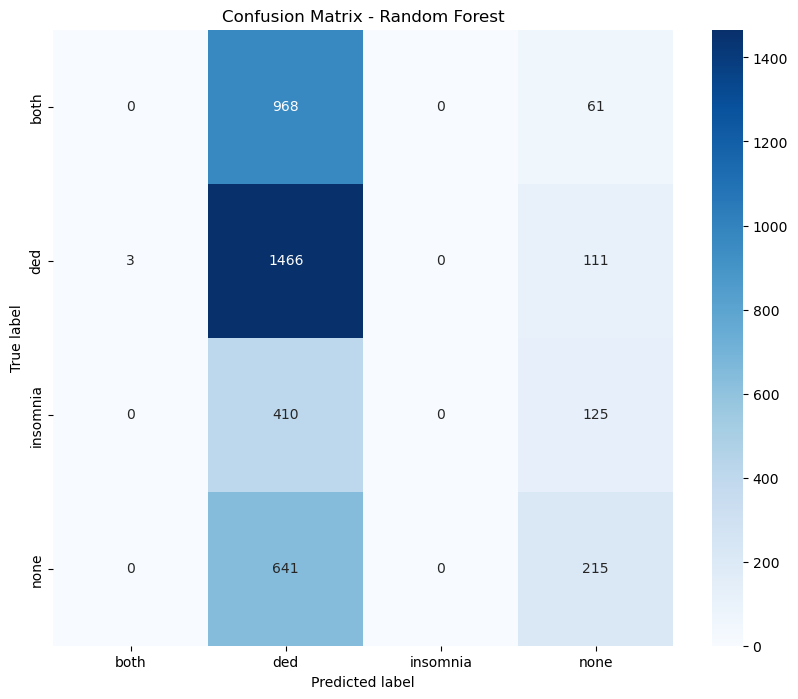

In [138]:
for name, clf in classifers.items():
    
    #5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=3)
    cv_scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
    
    #Fit the model
    
    clf.fit(X_train, y_train)

    #Predicting on training set

    y_pred_train = clf.predict(X_train)
    
    #Predicting on validation set
    
    y_pred_val = clf.predict(X_val)
    
    #Predicting on test set
    
    y_pred_test = clf.predict(X_test)
    
    #Evaluating from the metrics
    
    train_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    #Calculating the precision, recall, F1-score
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Print results
    print(f"\n{name} Classifier:")
    print(f"Training accuracy: {train_accuracy:.3f}")
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Validation accuracy: {val_accuracy:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1_score:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))
    
     # Plot confusion matrix with labels
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[disease_labels[i+1] for i in range(len(disease_labels))],
                yticklabels=[disease_labels[i+1] for i in range(len(disease_labels))])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [133]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 300, 500, 700],
    'max_depth': [1, 2, 3, 4, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print(grid_search.best_params_)

/Users/anweshabasu/miniconda3/envs/erdos_spring_2025/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 9.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 14.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3


In [ ]:
import pandas as pd
import xgboost as xgb
import shap

# Ensure you pass feature names explicitly
feature_names = dv.get_feature_names_out()  # If using DictVectorizer
# feature_names = X_train.columns  # If using a DataFrame (before transformation)

# Train XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Get feature importances
importances = xgb_model.feature_importances_

# Convert to DataFrame for better readability
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

print(feat_importance_df.head(10))  # Top 10 features

# ✅ SHAP Analysis (if needed)
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

# Plot SHAP summary
shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.05)
xgb.fit(X_train, y_train)
print(f"Train accuracy: {xgb.score(X_train, y_train):.3f}")
print(f"Test accuracy: {xgb.score(X_test, y_test):.3f}")

Train accuracy: 1.000
Test accuracy: 0.673


In [ ]:
6